# 道路骨架提取

In [ ]:
import geopandas as gpd
import momepy
import libpysal
from shapely.ops import voronoi_diagram

# 准备建筑shp

76


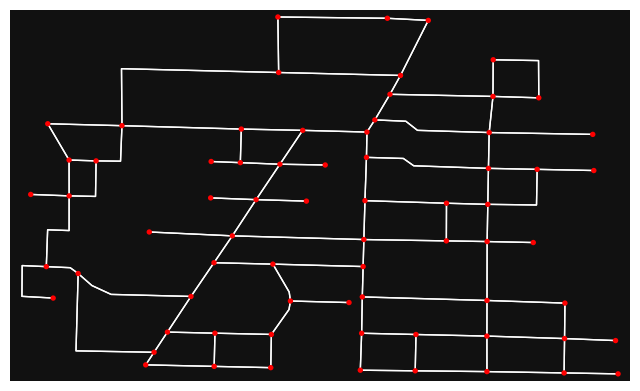

建筑物图层已保存为：buildings.shp


<Axes: >

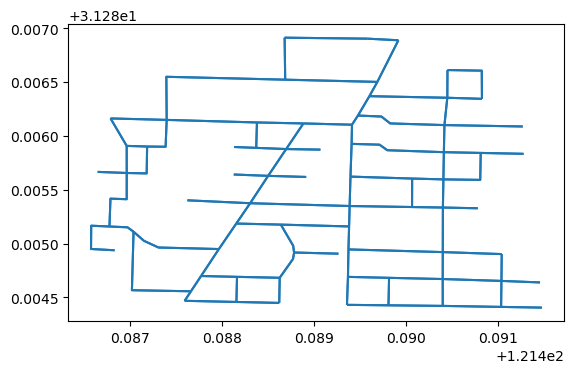

In [250]:
import osmnx as ox
import geopandas as gpd

# Step 1：设置区域名称
place_name = "赤峰小区"

# Step 2：下载该区域的建筑图层
buildings = ox.features_from_place(place_name, tags={'building': True})

print(len(buildings))

# Step 3：保留 polygon 类型（建筑轮廓）
buildings = buildings[buildings.geometry.type.isin(['Polygon', 'MultiPolygon'])]

# Step 4：保存为 Shapefile（可在 QGIS 中查看）
output_path = "buildings.shp"

buildings.to_file(output_path, encoding='utf-8')
G = ox.graph_from_place("赤峰小区", network_type='all')
ox.plot_graph(G, node_color='red', edge_color='white')
print(f"建筑物图层已保存为：{output_path}")
nodes,roads= ox.graph_to_gdfs(G, nodes=True, edges=True)
roads.plot()

D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\geopandas\array.py:1638: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))


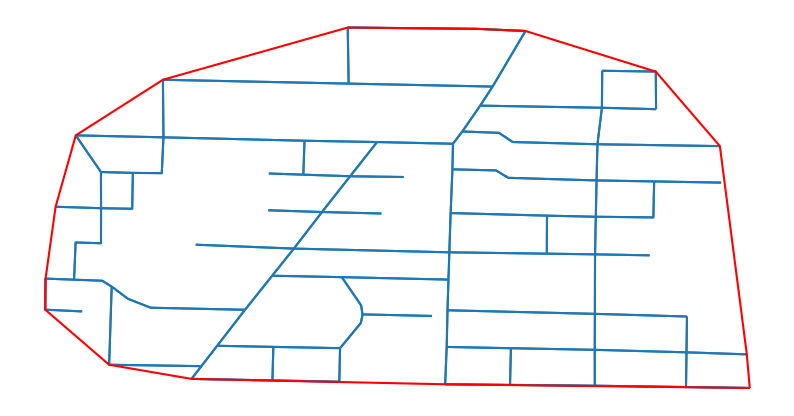

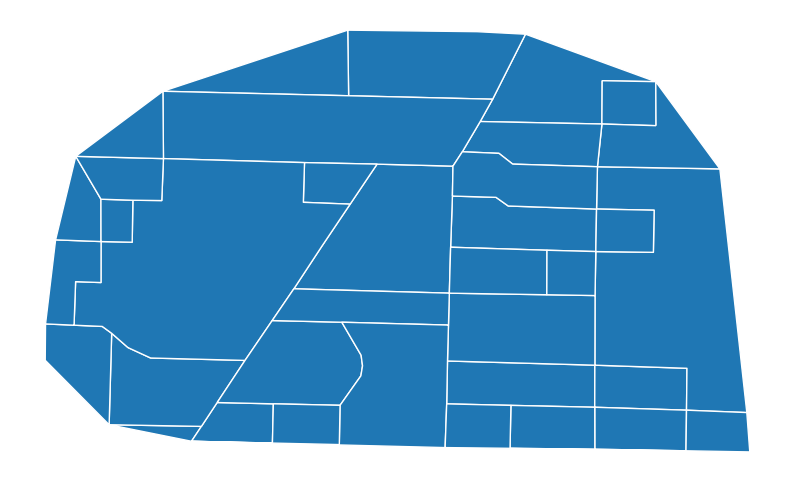

In [251]:
convex_hull = roads.union_all().convex_hull
enclosures = momepy.enclosures(roads, limit=convex_hull)
ax = roads.plot(figsize=(10, 10))
gpd.GeoSeries([convex_hull.boundary]).plot(ax=ax, color="r")
ax.set_axis_off()
enclosures.plot(figsize=(10, 10), edgecolor="w").set_axis_off()

76


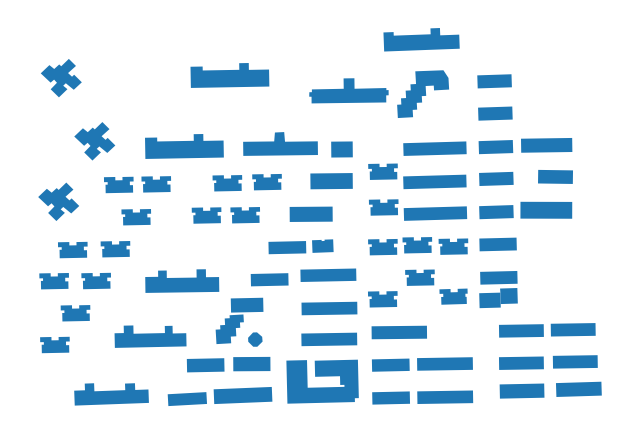

In [252]:
import momepy
import libpysal
from shapely.validation import make_valid
from shapely.geometry import Polygon, LineString
from shapely.errors import TopologicalError

# 建筑图层
buildings = gpd.read_file('buildings.shp').to_crs(epsg=32650)
print(len(buildings))
# 只保留 Polygon 或 MultiPolygon 类型

ax = buildings.plot(figsize=(8, 8))
ax.set_axis_off()



76
                                            geometry
0  MULTIPOLYGON (((927348.036 3469834.153, 927347...


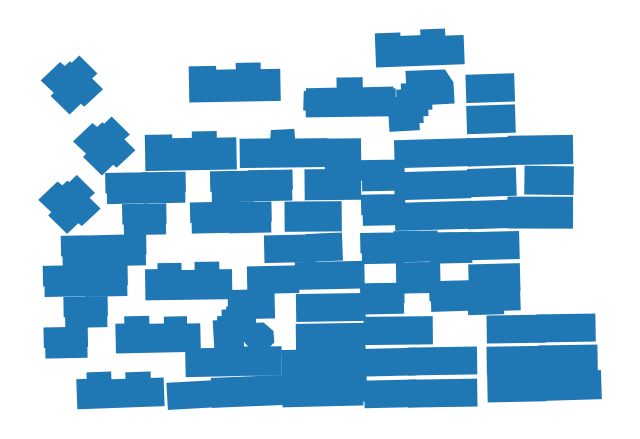

In [253]:
from shapely.ops import unary_union
from shapely.geometry import JOIN_STYLE

buildings_buffered_5m = buildings.copy()
buildings_buffered_5m["geometry"] = buildings_buffered_5m.geometry.buffer(5,join_style=JOIN_STYLE.mitre)
# 第二步：在原来基础上再扩 2 米，控制建筑之间的最小距离
buildings_buffered_7m = buildings_buffered_5m.copy()
buildings_buffered_7m["geometry"] = buildings_buffered_7m.geometry.buffer(2,join_style=JOIN_STYLE.mitre)
print(len(buildings))


# 第三步：将所有相交图形合并为单个 Polygon 或 MultiPolygon
merged_geometry = unary_union(buildings_buffered_7m.geometry)
merged_gdf = gpd.GeoDataFrame(geometry=[merged_geometry], crs=buildings.crs)

ax = buildings_buffered_7m.plot(figsize=(8, 8))
ax.set_axis_off()
print(merged_gdf)

merged_gdf = buildings_buffered_7m

In [254]:
# 添加唯一标识符
buildings['uid'] = range(len(buildings))
enclosures['eID'] = range(len(enclosures))
buildings = buildings.to_crs(epsg=32650)
enclosures = enclosures.to_crs(epsg=32650)
# 使用 momepy 进行封闭泰森多边形生成
tess = momepy.Tessellation(
    gdf=buildings,
    unique_id='uid',
    enclosures=enclosures,
    enclosure_id='eID',
    shrink=0.3,
    segment=0.5,
    threshold=0.05
)

# 结果提取
enclosed_tess = tess._enclosed_tessellation
ax = enclosed_tess.plot(edgecolor="white", figsize=(10, 10))
buildings.plot(ax=ax, color="black", alpha=0.5)
ax.set_axis_off()

AttributeError: 'SpatialIndex' object has no attribute 'query_bulk'

D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Empty GeoDataFrame
Columns: [element, id, building, name, amenity, geometry, uid]
Index: []
Empty GeoDataFrame
Columns: [element, id, building, name, amenity, geometry, uid]
Index: []
   element          id     building   name           amenity  \
67     way  1093102317   apartments   None              None   
69     way  1093102319   apartments   None              None   
70     way  1093102320   apartments   None              None   
71     way  1093102321  residential   None              None   
74     way  1093112843          yes  赤一居委会  community_centre   
75     way  1093112844          yes   None  community_centre   

                                             geometry  uid  
67  POLYGON ((927606.451 3470013.151, 927635.933 3...   67  
69  POLYGON ((927606.703 3469956.652, 927638.76 34...   69  
70  POLYGON ((927607.369 3469927.919, 927639.426 3...   70  
71  POLYGON ((927668.234 3469883.209, 927706.81 34...   71  
74  POLYGON ((927606.591 3469909.533, 927624.816 3...   74  
7

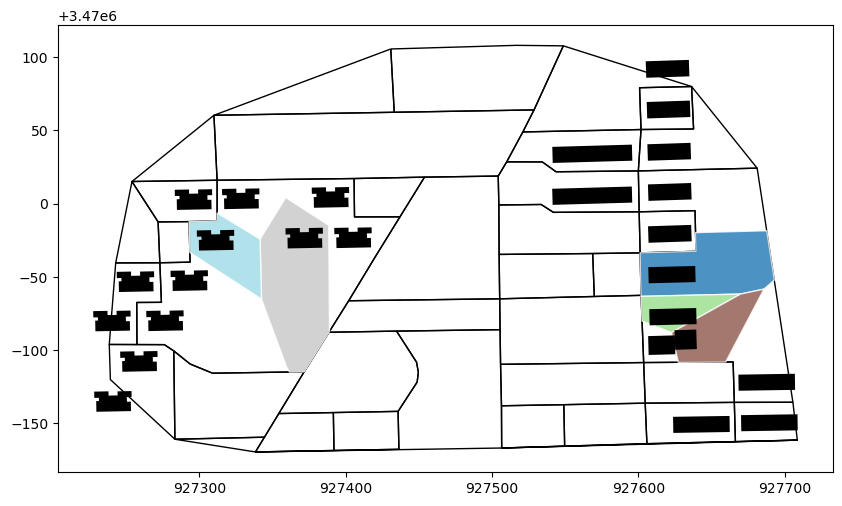

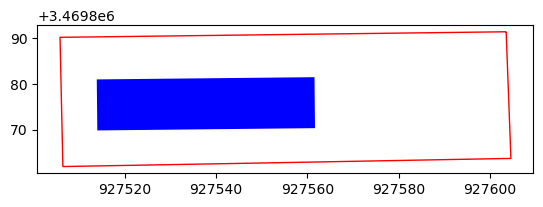

eID 1 有 1 个建筑


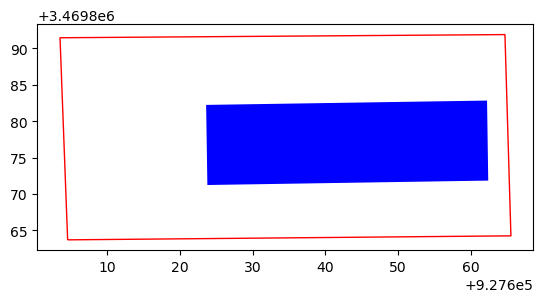

eID 2 有 8 个建筑


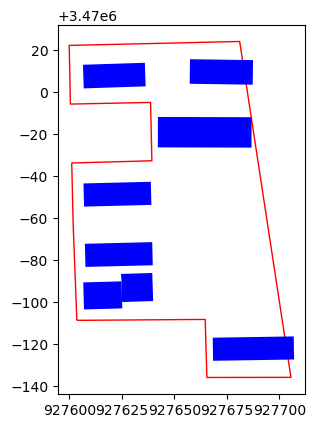

eID 3 有 3 个建筑


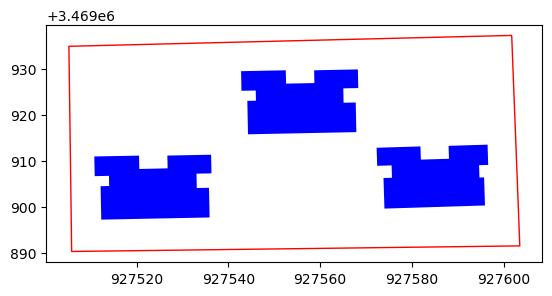

eID 4 有 1 个建筑


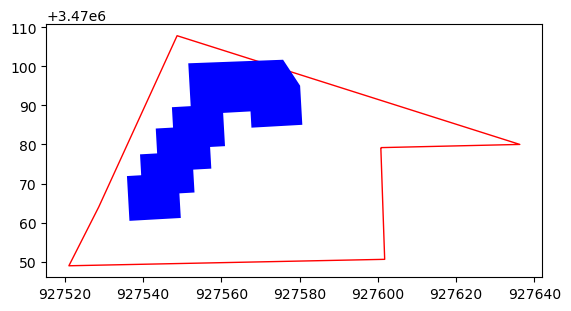

eID 5 有 1 个建筑


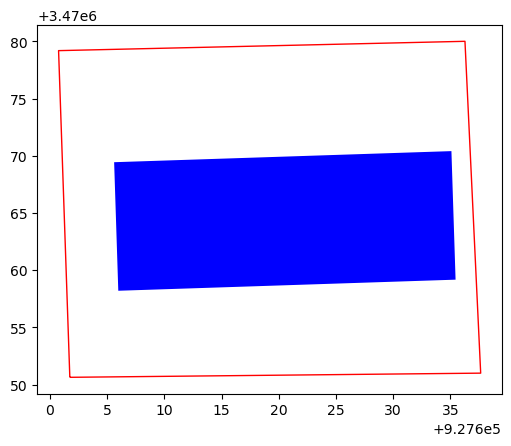

eID 6 有 2 个建筑


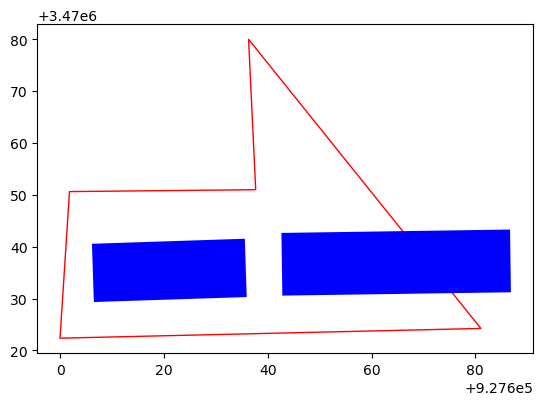

eID 7 有 1 个建筑


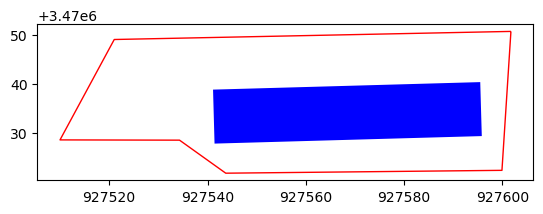

eID 8 有 1 个建筑


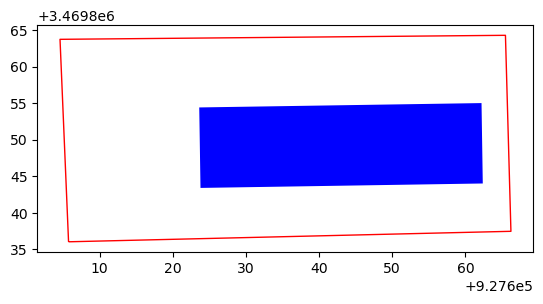

eID 9 有 1 个建筑


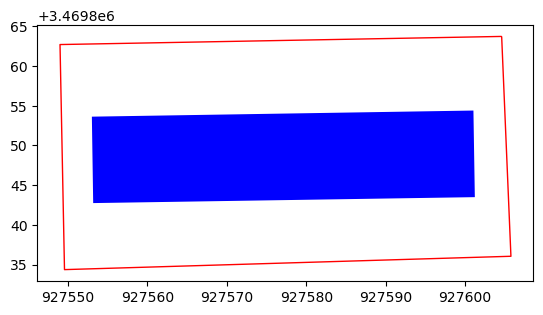

eID 10 有 0 个建筑


C:\Users\Elena\AppData\Local\Temp\ipykernel_7736\3622381903.py:81: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  inside.plot(ax=ax, color='blue')


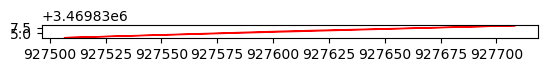

eID 11 有 1 个建筑


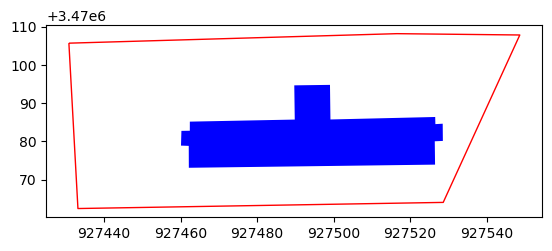

C:\Users\Elena\AppData\Local\Temp\ipykernel_7736\3622381903.py:81: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  inside.plot(ax=ax, color='blue')


eID 12 有 0 个建筑


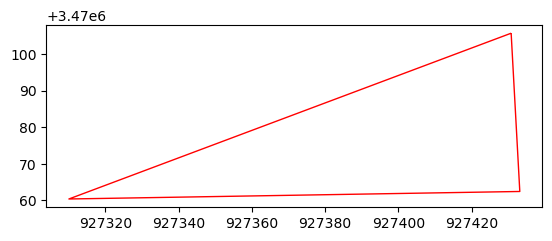

eID 13 有 2 个建筑


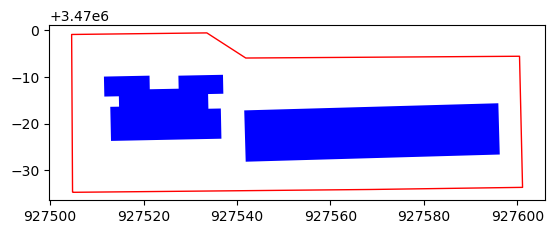

eID 14 有 4 个建筑


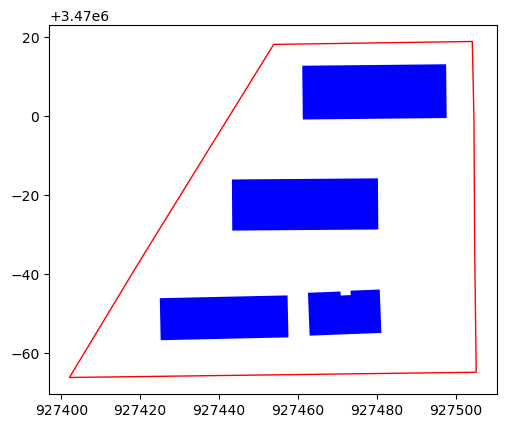

eID 15 有 2 个建筑


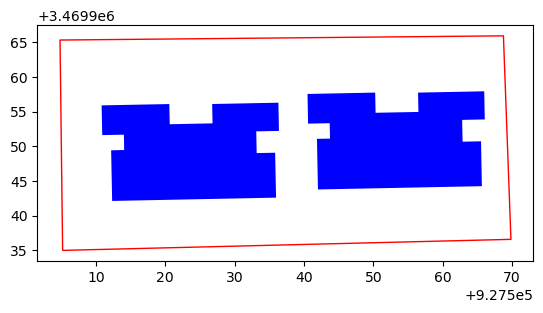

eID 16 有 3 个建筑


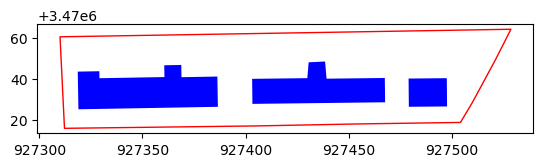

eID 17 有 2 个建筑


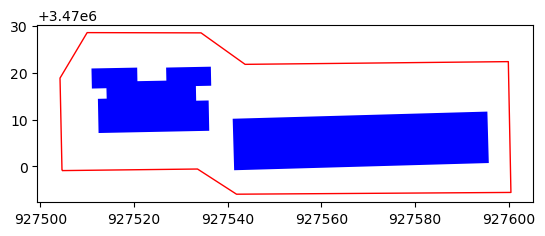

eID 18 有 1 个建筑


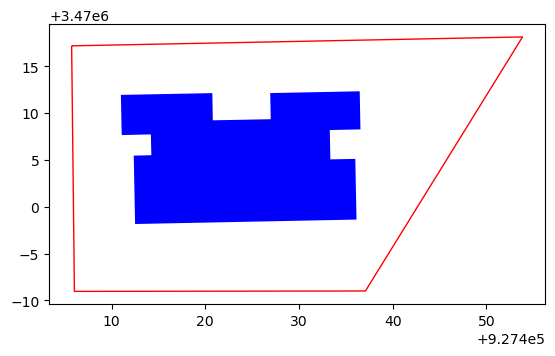

eID 19 有 0 个建筑


C:\Users\Elena\AppData\Local\Temp\ipykernel_7736\3622381903.py:81: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  inside.plot(ax=ax, color='blue')


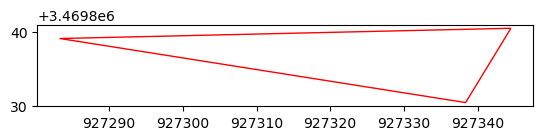

eID 20 有 1 个建筑


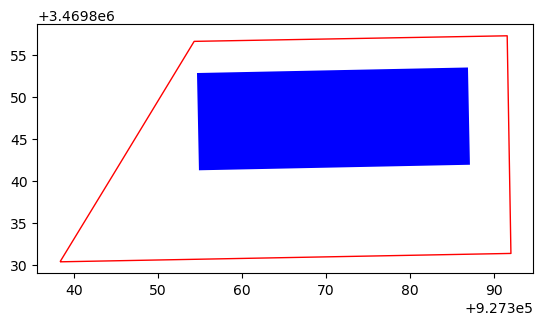

eID 21 有 1 个建筑


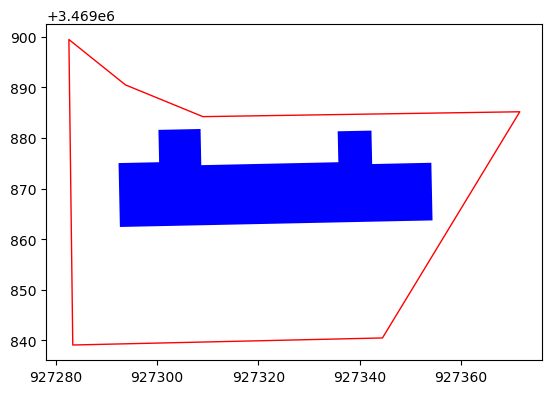

eID 22 有 1 个建筑


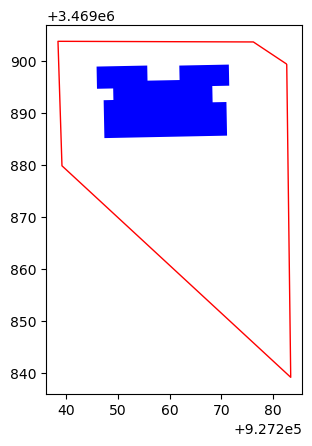

eID 23 有 8 个建筑


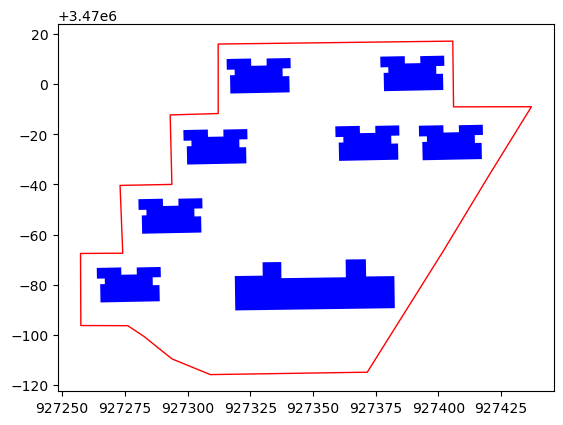

eID 24 有 3 个建筑


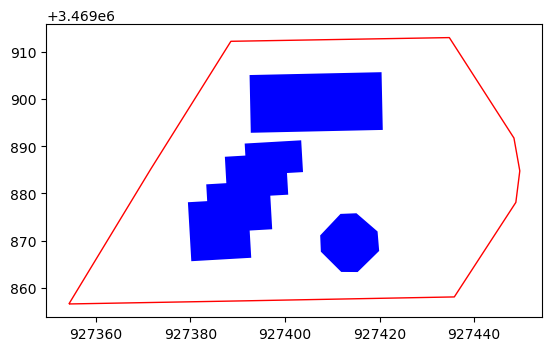

eID 25 有 2 个建筑


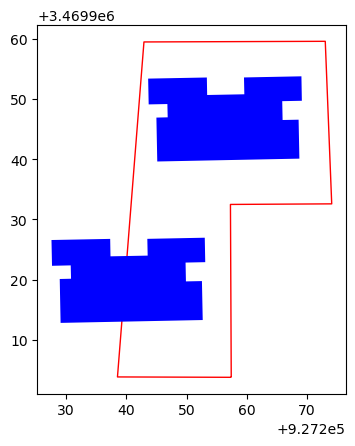

eID 26 有 0 个建筑


C:\Users\Elena\AppData\Local\Temp\ipykernel_7736\3622381903.py:81: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  inside.plot(ax=ax, color='blue')


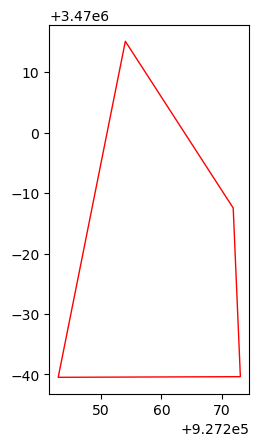

eID 27 有 0 个建筑


C:\Users\Elena\AppData\Local\Temp\ipykernel_7736\3622381903.py:81: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  inside.plot(ax=ax, color='blue')


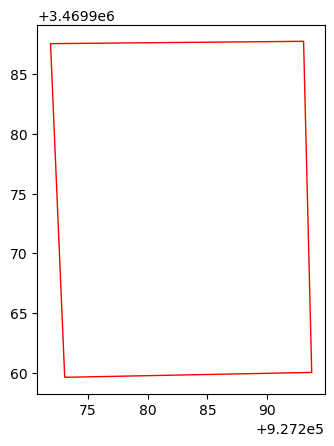

eID 28 有 1 个建筑


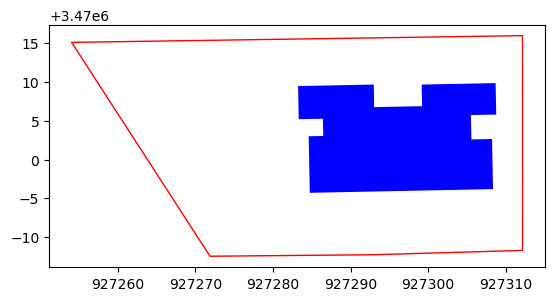

C:\Users\Elena\AppData\Local\Temp\ipykernel_7736\3622381903.py:81: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  inside.plot(ax=ax, color='blue')


eID 29 有 0 个建筑


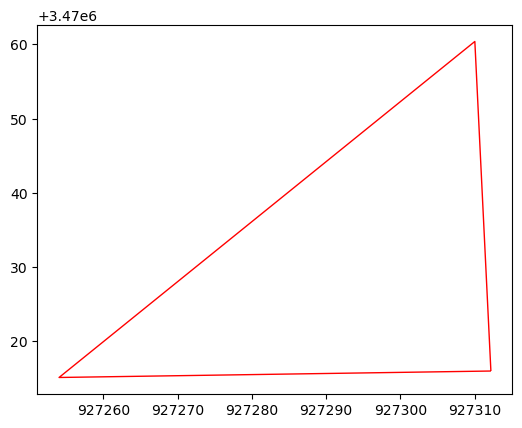

eID 30 有 1 个建筑


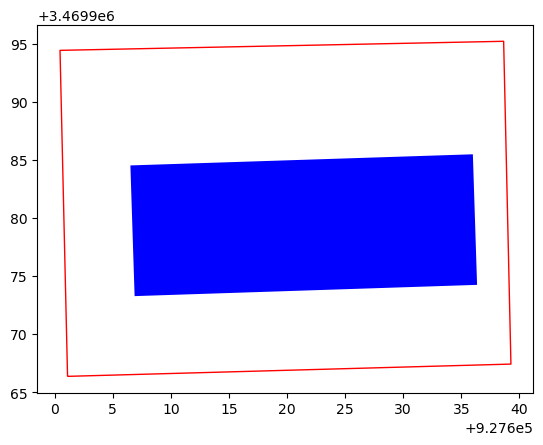

eID 31 有 1 个建筑


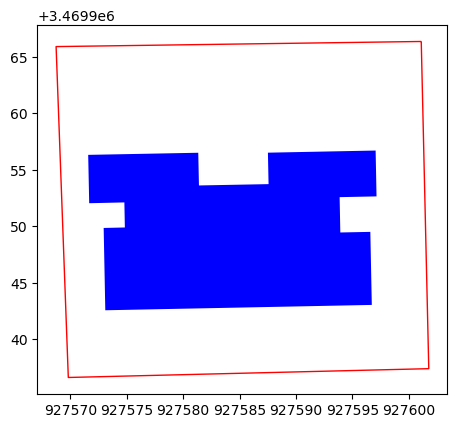

eID 32 有 2 个建筑


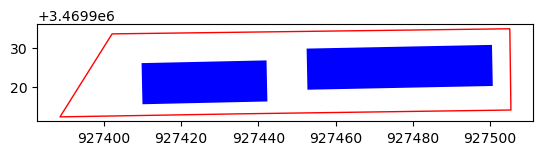

eID 33 有 3 个建筑


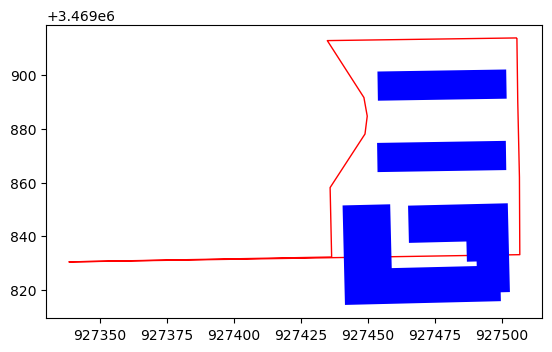

eID 34 有 1 个建筑


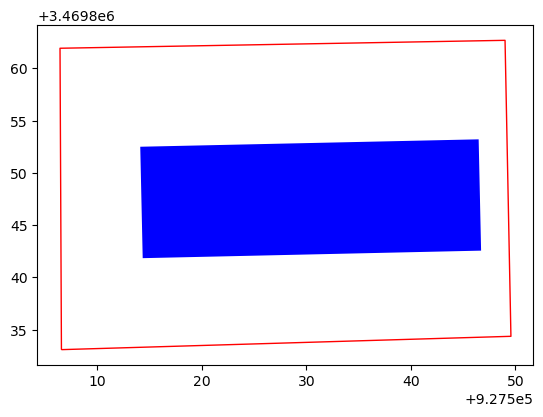

eID 35 有 1 个建筑


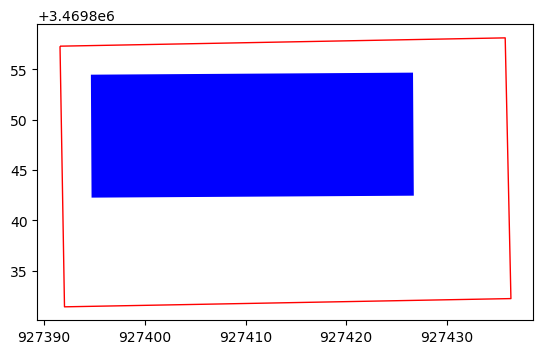

eID 36 有 1 个建筑


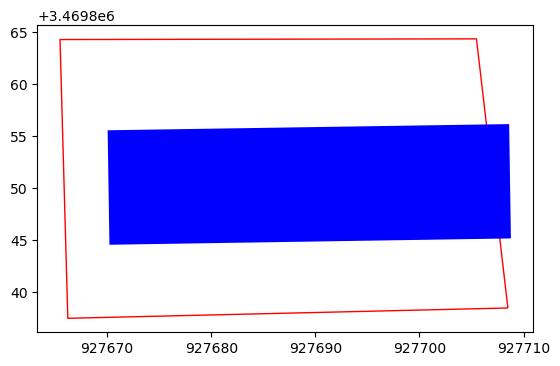

In [255]:
import geopandas as gpd
import pandas as pd
import shapely
from shapely.geometry import Point, Polygon, MultiPolygon
from scipy.spatial import Voronoi
import numpy as np

# 确保是投影坐标系（如 UTM）
buildings = buildings.to_crs(epsg=32650)
buildings_limit= buildings[50:100]
enclosures = enclosures.to_crs(epsg=32650)

# 添加 ID
buildings_limit["uid"] =buildings_limit.index
enclosures["eID"] = enclosures.index

# 结果列表
tess_cells = []

# 核心处理函数
def local_voronoi(points, boundary_poly, uid_list, eID):
    if len(points) < 3:
        return []  # 无法生成 Voronoi

    # Voronoi 生成
    vor = Voronoi(points)
    polygons = []

    for i, region_index in enumerate(vor.point_region):
        region = vor.regions[region_index]
        if -1 in region or len(region) == 0:
            continue  # 跳过无穷或无效
        poly = Polygon([vor.vertices[i] for i in region])
        poly_clipped = poly.intersection(boundary_poly)
        if poly_clipped.is_empty:
            continue
        polygons.append({
            "geometry": poly_clipped,
            "uid": uid_list[i],
            "eID": eID
        })

    return polygons

# 遍历每个 enclosure
for idx, row in enclosures.iterrows():
    eID = row["eID"]
    enclosure_geom = row["geometry"]

    # 找 enclosure 内的建筑
    inside = buildings_limit[buildings_limit.geometry.centroid.intersects(enclosure_geom)]
    print(inside)
    if len(inside) < 3:
        continue

    # 几何质心
    centroids = inside.geometry.centroid
    coords = [(pt.x, pt.y) for pt in centroids]
    uid_list = list(inside["uid"])

    # 生成泰森多边形
    local_cells = local_voronoi(coords, enclosure_geom, uid_list, eID)
    tess_cells.extend(local_cells)

# 合并为 GeoDataFrame
tessellation = gpd.GeoDataFrame(tess_cells, crs=buildings.crs)

# ✅ 可视化
ax = enclosures.plot(edgecolor="black", facecolor="none", figsize=(10, 10))
tessellation.plot(ax=ax, edgecolor="white", alpha=0.8, cmap="tab20")
buildings_limit.plot(ax=ax, color="black", markersize=5)
for idx, row in enclosures.iterrows():
    eID = row["eID"]
    enclosure_geom = row["geometry"]

    inside = buildings[buildings.geometry.centroid.intersects(enclosure_geom)]
    print(f"eID {eID} 有 {len(inside)} 个建筑")

    # 可视化这个 enclosure 和其中的建筑
    ax = gpd.GeoSeries([enclosure_geom]).plot(facecolor='none', edgecolor='red')
    inside.plot(ax=ax, color='blue')
    plt.show()
